# OpenCV - Procesamiento de imagenes
![](https://pyimagesearch.com/wp-content/uploads/2018/05/opencv_tutorial_header.jpg)

Vamos a revisar como integrar OpenCV tanto con Matplotlib como con tkinter, así como algunas aplicaciones de procesmiento de imágenes y manipulación de los pixels.

Luis A. Muñoz (2022)

---

## Integración de OpenCV con otras librerías
Es posible integrar OpenCV tanto con Matplotlib como con tkinter.

### OpenCV y matplotlib
Por incompatibilidad con el modelo BGR (OpenCV) y RGB (matplotlib) se suelen visualizar las imagenes en escala de grises, aunque se puede hacer una conversion de un modelo a otro utilizando el método `cv2.cvtColor(img, FILTER)` a RGB.

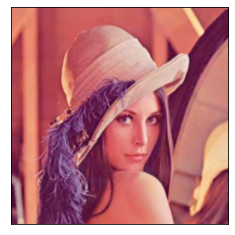

In [2]:
import matplotlib.pyplot as plt
import cv2

#cv_img = cv2.imread("img\\sample.jpg", cv2.IMREAD_GRAYSCALE)
cv_img = cv2.imread("img\\sample.jpg")
cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

#plt.imshow(cv_img, cmap='gray', interpolation='bicubic')
plt.imshow(cv_img_rgb, interpolation='bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

### OpenCV y tkinter
Insertar una imagen en una aplicación gráfica hecha con tkinter requiere ciertas adecuaciones en la imagen leída utilizando cv2:

* Convertir la imagen de BGR a RGB (colores o escala de grises) con los filtros de `cv2.cvtColor`
* Crear un objeto PIL.PhotoImage del arreglo numpy de la imagen
* Convertir el objeto PIL.PhotoImage en un objeto PIL.ImageTk.PhotoImage para poder insertarlo en un widget
* Insertar la imagen en un Canvas o en un Label y mantener la referencia con *widget.image = imagen insertada*

Este ultimo paso es un detalle técnico que evita que la imagen sea trasparente (y no se vea) por un problema de referencias entre archivos y los objetos Tk (garbage collector).

Los widgets que soportan la propiedad image son `Label`, `Text` y `Canvas`.

In [1]:
import tkinter as tk
from PIL import Image, ImageTk
import cv2

class App(tk.Tk):
    def __init__(self):
        super().__init__()
        width, height = 600, 400
        self.title("Image Viewer")
        self.resizable(0, 0)
        
        self.canvas = tk.Canvas(self, width=width, height=height, borderwidth=1, relief='sunken')
        self.canvas.pack()
    
        cv_img = cv2.imread("img\\sample.jpg")
        cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
        cv_img_re = cv2.resize(cv_img_rgb, (width, height))
        
        try:
            photo = ImageTk.PhotoImage(image=Image.fromarray(cv_img_re))
            self.canvas.create_image(0, 0, image=photo, anchor='nw')
            self.canvas.image = photo    # REFERENCIA - (garbage collector)
        except:
            pass

        
app = App().mainloop()

## Aplicación: Kiosko de fotos
Al integrar OpenCV con tkinter se pueden crear aplicaciones que integren el procesamiento de imagenes al repertorio de aplicaciones de escritorio.

In [2]:
import tkinter as tk
from PIL import Image, ImageTk
import cv2
from datetime import datetime
from tkinter.messagebox import showinfo

class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.width, self.height = 600, 400
        self.title("Photo Kiosk")
        self.resizable(0, 0)
        
        self.protocol("WM_DELETE_WINDOW", self.quit)
        
        self.cap = cv2.VideoCapture(0)
        
        frm1 = tk.LabelFrame(self, text="Image Preview")
        frm2 = tk.Frame(self)
        frm1.pack(padx=10, pady=10)
        frm2.pack(padx=10, pady=10)
        
        self.canvas = tk.Canvas(frm1, width=self.width, height=self.height, borderwidth=1, relief='sunken')
        self.canvas.pack()
        
        self.btnTakePic = tk.Button(frm2, text="Take Pic!", width=24, font="Arial 12 bold", command=self.take_pic)
        self.btnTakePic.pack(padx=5, pady=5)
        
        self.update_image()
        
        
    def update_image(self):
        ret, frame = self.cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (self.width, self.height))
        
        try:
            photo = ImageTk.PhotoImage(image=Image.fromarray(frame))
            self.canvas.create_image(0, 0, image=photo, anchor='nw')
            self.canvas.image = photo
        except:
            pass
        
        self.after(100, self.update_image)
        
        
    def take_pic(self):
        ret, frame = self.cap.read()
        filename = f"img\\{datetime.now():'%d%m%Y_%H_%M'}.jpg"
        cv2.imwrite(filename, frame)
        showinfo("Picture Saved", f"Se guardo una captura de la imagen en {filename}")
        
        
    def quit(self):
        if self.cap.isOpened():
            self.cap.release()
        self.destroy()
        
        
app = App().mainloop()

## Aplicación: Insersión de logos (binary masking)
Al ser las imagenes un arreglo bidimenional de números, estos se pueden manipular de forma aritmética. Pero si estos números se convierten en valores binarios (en un proceso de thresholding) se pueden hacer operaciones lógicas a nivel de pixels.

In [3]:
import cv2

TAM_IMAGEN = (80, 80)

def put_logo_over_image(img, logo):
    # Se extrae la imagen del logo y se obtiene la version binaria y su forma invertida
    gray = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Se utliza la mascara binaria para el fondo y la máscara invertida para el frente
    mask_con_fondo = cv2.bitwise_and(roi, roi, mask=mask)
    mask_con_frente = cv2.bitwise_and(logo, logo, mask=mask_inv)

    # Se suman las imágenes combinadas en una sola
    dst = cv2.add(mask_con_fondo, mask_con_frente)
    
    return dst
    

cap = cv2.VideoCapture(0)

while True:
    ret, img = cap.read()
    logo = cv2.imread("img\\upc_logo.jpg", cv2.IMREAD_COLOR)
    logo = cv2.resize(logo, TAM_IMAGEN)
    
    # ROI de la imagen: esquina inferior derecha
    roi = img[-TAM_IMAGEN[0] - 20:-20, -20 - TAM_IMAGEN[0]:-20]
    
    roi_con_logo = put_logo_over_image(roi, logo)
    img[-TAM_IMAGEN[0] - 20:-20, -20 - TAM_IMAGEN[0]:-20] = roi_con_logo
    
    cv2.imshow("Video Logo", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## Mascaras con inRange (Deteccion de colores)
![](https://i.stack.imgur.com/gyuw4.png)

Se pueden confeccionar máscaras asociadas a un rango de valores de color, utilizado el modelo de color HSV (Hue, Saturation, Value) que permite detectar colores iluminados por luz natural.

In [16]:
import cv2
import numpy as np

img = cv2.imread("img\\people_green_bg.jpg", cv2.IMREAD_COLOR)
img_bg = cv2.imread("img\\office_bg.jpg", cv2.IMREAD_COLOR)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

print("Chroma Key Color HSV:", img_hsv[10, 10, :])    # HUE, SATURATION, VALUE

lower_bound = np.array([40, 200, 255])
upper_bound = np.array([85, 255, 255])
mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
mask_inv = cv2.bitwise_not(mask)

kernel = np.ones((3, 3), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
mask_inv = cv2.erode(mask_inv, kernel, iterations=1)

img_mask = cv2.bitwise_and(img, img, mask=mask_inv)

cv2.imshow('img', img)
cv2.imshow('mask', mask)
cv2.imshow('img_mask', img_mask)

roi = img_bg[-img_mask.shape[0]:,-img_mask.shape[1]:,:]
img_bg2 = cv2.bitwise_and(roi, roi, mask=mask)

dst = cv2.add(img_mask, img_bg2)
cv2.imshow('Final', dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

Chroma Key Color HSV: [ 57 238 255]


## Detección de contornos
El algoritmo de detección de contornos busca pixels adyacentes que tengan las mismas propiedades. El algoritmo requiere un tratamiento inicial de la imágen para hacer más fácil la detección de los bordes.

In [21]:
import cv2
import numpy as np

# Se detectan objetos de color rojo, verde o azul
cap = cv2.VideoCapture(0)

kernel_open = np.ones((30, 30))
kernel_close = np.ones((100, 100))

while True:
    ret, frame = cap.read()
    
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    mask1 = cv2.inRange(img_hsv, (0,50,20), (5,255,255))        # Rango inferior rojo
    mask2 = cv2.inRange(img_hsv, (160,50,20), (180,255,255))    # Rango superior rojo
    mask = cv2.bitwise_or(mask1, mask2)
    
    # erosion + dilation: elimina puntos blancos
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)          
    # dilation + erosion: elimina agujeros negros
    mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_close)
    
    mask_final = mask_close
    
    # Se hallan los contornos de la imagen (blanco sobre fondo negro)
    conts, h = cv2.findContours(mask_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #cv2.drawContours(frame, conts, -1, (255, 0, 0), 3)
    
    for i in range(len(conts)):
        x, y, w, h = cv2.boundingRect(conts[i])
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
           
    cv2.imshow("WebCam", frame)
    cv2.imshow("Mask Final", mask_final)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## Haar Cascade Detection - Detección de rostros
La detección de objetos utilizando un clasificador de cascada de propiedades (Haar Cascade feature-based detection) es un método de detección efectivo propuesto por Paul Viola y Michael Jones en 2001. Es una aproximación basada en Machine Learning donde una función cascada es entrenada de una muestra de imágenes positivas y negativas. 

Para detectar un rostro, el algoritmo necesita muchas imágenes positivas y negativas para el entrenamiento del modelo clasificador. Lo que hace el algoritmo es extraer las características de un rostro. Para esto se parte un conjunto de caracteristicas: patrones de zonas oscuras e iluminadas que operarán como kernels de convolución.

![](https://docs.opencv.org/3.4/haar_features.jpg)

Con estas características se genera un modelo de rostro que va acumulando las diferentes caracteristicas en estados, de tal forma que en lugar de hacer un proceso complejo de revisar los detalles de una imagen, se hacen varios pasos simples de detección de cada una de las características de un rostro, en una especie de cascada de propiedades, en donde una imágen pasa de estado "puede ser un rostro" a "es un rostro" o "no es un rostro", dependiendo si va acumulando características del modelo generado.

In [22]:
import cv2
import numpy as np

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)   # imagen(gray), escala, # min vecinos
    
    for x, y, w, h in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
    cv2.imshow('WebCam', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()